In [1]:
from pydataset import data
from wrangle import split_data, scale_data
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### Will try to predict ACT score using SAT, age, gender, and education information

In [2]:
df=data('sat.act')

In [3]:
# Dropping 13 rows with NaN for SATQ
df = df.dropna()

In [4]:
# Not with NaN drop can convert to int64 to match other column dtypes
df.SATQ = df.SATQ.astype('int64')

In [5]:
df.gender = df.gender.map({2:'female',1:'male'})

In [6]:
# Encode gender. Education and age can be left as it as they represent ordinal data
df = pd.concat([df, pd.get_dummies(df.gender, drop_first=True, prefix='is')],axis=1)

In [7]:
df.head()

,gender,education,age,ACT,SATV,SATQ,is_male
29442,female,3,19,24,500,500,0
29457,female,3,23,35,600,500,0
29498,female,3,20,21,480,470,0
29503,male,4,27,26,550,520,1
29504,male,2,33,31,600,550,1


In [8]:
train, validate, test = split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [11]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, ['education','age','SATV','SATQ'])

In [16]:
X_train_exp = train[['gender','education','age','SATV','SATQ','is_male']] ## Unscaled, dummy vars with original categorical vars
X_train = train_scaled[['is_male','education_scaled','age_scaled','SATV_scaled','SATQ_scaled']]
y_train = train['ACT'] ## Unscaled, target variable only

X_validate = validate_scaled[['is_male','education_scaled','age_scaled','SATV_scaled','SATQ_scaled']]
y_validate= validate['ACT'] ## Unscaled, target variable only

X_test= test_scaled[['is_male','education_scaled','age_scaled','SATV_scaled','SATQ_scaled']]
y_test = test['ACT'] ## Unscaled, target variable only



## Explore target

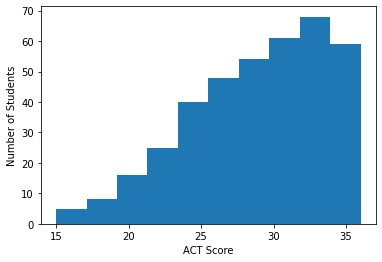

In [10]:
plt.hist(y_train)
plt.xlabel('ACT Score')
plt.ylabel('Number of Students')
plt.show()

### Baseline

In [18]:
# Make these dataframes to allow for baselines to be appended
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict mean
ACT_pred_mean_train = y_train.ACT.mean()
ACT_pred_mean_validate = y_validate.ACT.mean()
y_train['ACT_pred_mean_train'] = ACT_pred_mean
y_validate['ACT_pred_mean_validate'] = ACT_pred_mean

# Predict median
ACT_pred_median_train = y_train.ACT.median()
ACT_pred_median_validate = y_validate.ACT.median()
y_train['ACT_pred_median_train'] = ACT_pred_median
y_validate['ACT_pred_median_validate'] = ACT_pred_median

# RMSE of ACT pred mean

rmse_train = mean_squared_error(y_train.ACT, y_train.ACT_pred_mean_train, squared = False)
rmse_validate = mean_squared_error(y_validate.ACT, y_validate.ACT_pred_mean_validate, squared = False)

print(f"RMSE using Mean Train Sample: {round(rmse_train,2)}")
print(f"RMSE using Mean Validate Sample: {round(rmse_validate,2)}")

# RMSE of ACT pred median

rmse_train = mean_squared_error(y_train.ACT, y_train.ACT_pred_median_train, squared = False)
rmse_validate = mean_squared_error(y_validate.ACT, y_validate.ACT_pred_median_validate, squared = False)

print(f"RMSE using Median Train Sample: {round(rmse_train,2)}")
print(f"RMSE using Median Validate Sample: {round(rmse_validate,2)}")

RMSE using Mean Train Sample: 4.54
RMSE using Mean Validate Sample: 5.56
RMSE using Median Train Sample: 4.55
RMSE using Median Validate Sample: 5.62


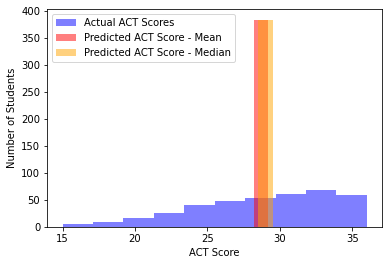

In [20]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.ACT, color='blue', alpha=.5, label="Actual ACT Scores")
plt.hist(y_train.ACT_pred_mean_train, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted ACT Score - Mean")
plt.hist(y_train.ACT_pred_median_train, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted ACT Score - Median")
plt.xlabel("ACT Score")
plt.ylabel("Number of Students")
plt.legend()
plt.show()


## Linear Regression (OLS):
1. Fit model using X_train_scaled and labels from y_train
2. Predict ACT scores using training sample using lm model
3. Evaluate using RMSE
4. Repeat predictions and evaluations for validation
5. Compare RMSE train vs validation to check for overfitting.

In [21]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.ACT)

# predict train
y_train['ACT_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.ACT, y_train.ACT_pred_lm, squared=False)

# predict validate
y_validate['ACT_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.ACT, y_validate.ACT_pred_lm, squared=False)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  3.4945834801683104 
Validation/Out-of-Sample:  4.251860938733075


In [23]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.ACT)

# predict train
y_train['ACT_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.ACT, y_train.ACT_pred_lars, squared=False)

# predict validate
y_validate['ACT_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.ACT, y_validate.ACT_pred_lars, squared=False)

print("RMSE for OLS using Lasso+Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)



RMSE for OLS using Lasso+Lars
Training/In-Sample:  4.543355925091713 
Validation/Out-of-Sample:  5.562759778844126


In [25]:
# create the model object
glm = TweedieRegressor(power=1,alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.ACT)

# predict train
y_train['ACT_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.ACT, y_train.ACT_pred_glm, squared=False)

# predict validate
y_validate['ACT_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.ACT, y_validate.ACT_pred_glm, squared=False)

print("RMSE for OLS using Tweedie, power=1 alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)




RMSE for OLS using Tweedie, power=1 alpha=0
Training/In-Sample:  3.466147522671559 
Validation/Out-of-Sample:  4.229031669155937


In [26]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [27]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.ACT)

# predict train
y_train['ACT_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.ACT, y_train.ACT_pred_lm2)**(1/2)

# predict validate
y_validate['ACT_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.ACT, y_validate.ACT_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  3.3044380413846124 
Validation/Out-of-Sample:  4.163083205060059


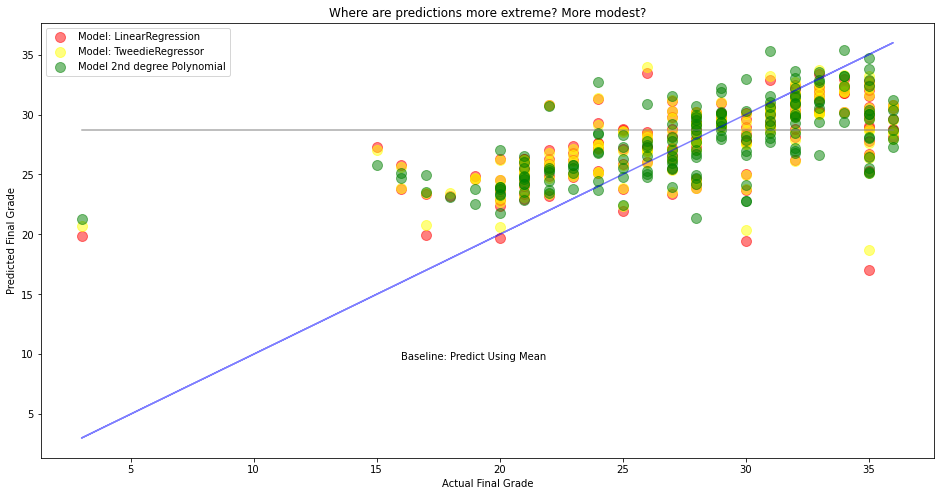

In [28]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.ACT, y_validate.ACT_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.ACT, y_validate.ACT, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.ACT, y_validate.ACT_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.ACT, y_validate.ACT_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.ACT, y_validate.ACT_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()
